In [1]:
%matplotlib inline

import os #used for system commands
import tempfile #used to create temporary folders to store data
import tarfile #used to extract tar files
import urllib #used to download data via http
from datetime import datetime #used to manipulate time :)
from glob import glob #used for manipulating pathnames

import numpy as np 
from matplotlib import pyplot as plt

import cartopy.crs as ccrs # A toolkit for map projections
import cartopy.feature as cfeature # A method for adding coastlines etc
import cartopy.io.img_tiles as cimgt # an API into things like google maps

from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress, metrics
# wait for jobs to arrive, depending on the queue, this may take some time
import dask.array as da
import dask.bag as db
import numpy as np
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import matplotlib.dates as mdates
from netCDF4 import num2date

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [3]:
print('hello world')

hello world


In [4]:
#Building the request url

#Specific the radar and date we want to download
radar_id     = 50 #this is the Marburg radar near Brisbane.
date         = '2014/11/27' #in yyyy/mm/dd
base_url     = 'http://dapds00.nci.org.au/thredds/fileServer/rq0' #base url for NCI dataset

#parse inputs
radar_id_str = str(radar_id).zfill(2) #convert radar id to a string and fill with a leading 0 if only one digit
date_dt      = datetime.strptime(date,'%Y/%m/%d')

#build request filename url
tar_fn       = radar_id_str + '_' + date_dt.strftime('%Y%m%d') + '.pvol.tar'
request_url  = '/'.join([base_url, radar_id_str, date_dt.strftime('%Y'), 'vol', tar_fn])
print('my request is ',request_url)

my request is  http://dapds00.nci.org.au/thredds/fileServer/rq0/50/2014/vol/50_20141127.pvol.tar


In [5]:
#downloading and extracting the data

#download the tar file
if not os.path.isfile(tar_fn):
    urllib.request.urlretrieve(request_url, tar_fn)

#extract the tar file to a temporary directory
temp_dir = '/home/scollis/aus_temp/'
tar = tarfile.open(tar_fn)
tar.extractall(path = temp_dir)
tar.close()

#list all the volumes extracted from the tar file
file_list = sorted(glob(temp_dir + '/*'))
print('\n'.join(file_list)) #print with newline between each list item

/home/scollis/aus_temp/50_20141127_000152.pvol.h5
/home/scollis/aus_temp/50_20141127_001152.pvol.h5
/home/scollis/aus_temp/50_20141127_002152.pvol.h5
/home/scollis/aus_temp/50_20141127_003152.pvol.h5
/home/scollis/aus_temp/50_20141127_004152.pvol.h5
/home/scollis/aus_temp/50_20141127_005152.pvol.h5
/home/scollis/aus_temp/50_20141127_010152.pvol.h5
/home/scollis/aus_temp/50_20141127_011152.pvol.h5
/home/scollis/aus_temp/50_20141127_012152.pvol.h5
/home/scollis/aus_temp/50_20141127_013152.pvol.h5
/home/scollis/aus_temp/50_20141127_014152.pvol.h5
/home/scollis/aus_temp/50_20141127_015152.pvol.h5
/home/scollis/aus_temp/50_20141127_020152.pvol.h5
/home/scollis/aus_temp/50_20141127_021152.pvol.h5
/home/scollis/aus_temp/50_20141127_022152.pvol.h5
/home/scollis/aus_temp/50_20141127_023152.pvol.h5
/home/scollis/aus_temp/50_20141127_024152.pvol.h5
/home/scollis/aus_temp/50_20141127_025152.pvol.h5
/home/scollis/aus_temp/50_20141127_030152.pvol.h5
/home/scollis/aus_temp/50_20141127_031152.pvol.h5


In [6]:
radar = pyart.aux_io.read_odim_h5(file_list[40])

In [7]:
#now for someting quantitative.. WARNING.. NEXRAD Z-R dont use for Marburg :)
rain_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
radar.fields['rain_z']['units'] = 'mm/h'
radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
radar.fields['rain_z']['valid_min'] = 0
radar.fields['rain_z']['valid_max'] = 500

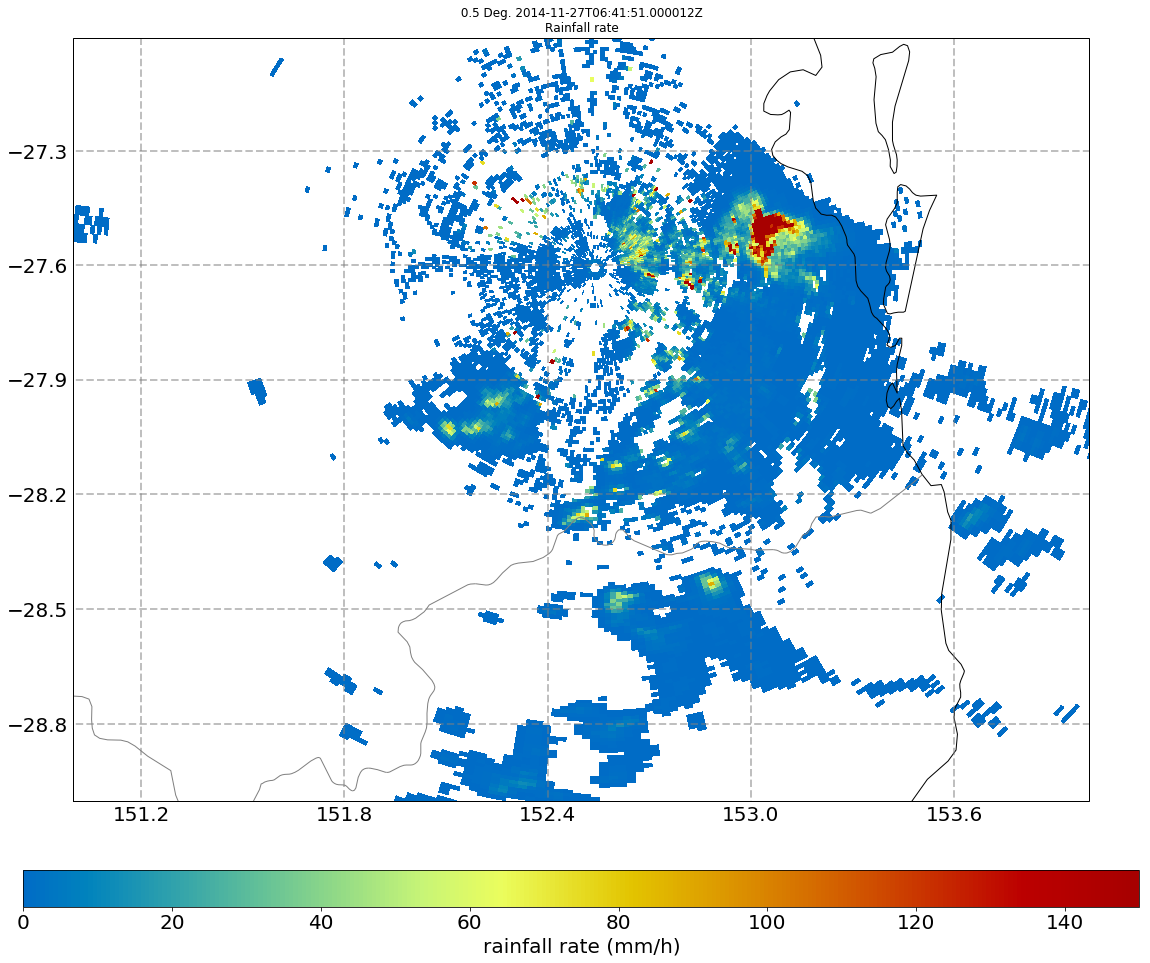

In [8]:
how_far_south = 0.2

lats = radar.gate_latitude
lons = radar.gate_longitude
min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

#set up the plot
myf = plt.figure(figsize=[20,18])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Set up the GIS projection
projection = ccrs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat-how_far_south, max_latitude=max_lat)

#plot a PPI. We specifically ask Py-ART not to add the colorbar... 
#We will customize this to make it nice.

display.plot_ppi_map(
    'rain_z', 0,
    projection=projection, colorbar_flag=False,
    vmin=0, vmax=150, cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
    resolution='10m')

display.ax.set_extent([151, 154, -29, -27])

#here is our pretty colorbar code
lb = display._get_colorbar_label('rain_z')
cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                  orientation='horizontal')

cb.ax.tick_params(labelsize=20)

cb.set_label(lb, fontsize=20)

#Now we add lat lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5,
                          linestyle='--')

gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

gl.xlabels_top = False
gl.ylabels_right = False

In [9]:
r_threshold = 50.0
#where command gives you range, ray pairs where a condition is met
#so we take the first element (the time array) and get the lenghth of that 
n_gates_over = np.where(radar.get_field(0, 'rain_z') > r_threshold)[0].shape[0]

#Now take the total gates to get percentage
total_gates = radar.get_field(0, 'rain_z').shape[0] * radar.get_field(0, 'rain_z').shape[1]
percentage_over = 100.0 * n_gates_over/total_gates
print(percentage_over, '% of gates are over ', r_threshold)

0.5161854768153981 % of gates are over  50.0


In [10]:
def fetch_per_gates(filename):
    radar = pyart.aux_io.read_odim_h5(filename)
    #now for someting quantitative.. WARNING.. NEXRAD Z-R dont use for MtSt :)
    rain_z = radar.fields['reflectivity']['data'].copy()
    z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
    rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
    radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
    radar.fields['rain_z']['units'] = 'mm/h'
    radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
    radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
    radar.fields['rain_z']['valid_min'] = 0
    radar.fields['rain_z']['valid_max'] = 500
    r_threshold = 50.0
    #where command gives you range, ray pairs where a condition is met
    #so we take the first element (the time array) and get the lenghth of that 
    n_gates_over = np.where(radar.get_field(0, 'rain_z') > r_threshold)[0].shape[0]

    #Now take the total gates to get percentage
    total_gates = radar.get_field(0, 'rain_z').shape[0] * radar.get_field(0, 'rain_z').shape[1]
    percentage_over = 100.0 * n_gates_over/total_gates
    print(percentage_over, '% of gates are over ', r_threshold)
    del(radar)
    return percentage_over

In [ ]:
fetch_per_gates(file_list[30])

In [11]:
cluster = SLURMCluster(cores=18, project='acpc', walltime='0:15:00', memory='128GB')

cluster.scale(4)         # Ask for 36 workers
client = Client(cluster)  # Connect this local process to remote workers

/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/tornado/concurrent.py:521: DeprecationWarning: @return_future is deprecated, use coroutines instead
  DeprecationWarning)


In [12]:
cluster

In [13]:
future = client.map(fetch_per_gates, file_list)

In [14]:
progress(future)

VBox()

/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(FloatProgress).__init__(height='10px').
object.__init__() takes no parameters
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(HTML).__init__(width='140px').
object.__init__() takes no parameters
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


In [15]:
my_data = client.gather(future)

In [16]:

#now let's read the datetime numbers of all the volumes for comparision
file_dt_list = []
for i, fname in enumerate(file_list):
    file_dt_list.append(datetime.strptime(os.path.basename(fname)[3:18],'%Y%m%d_%H%M%S'))


Text(0,0.5,'Percentage over 50mm/h')

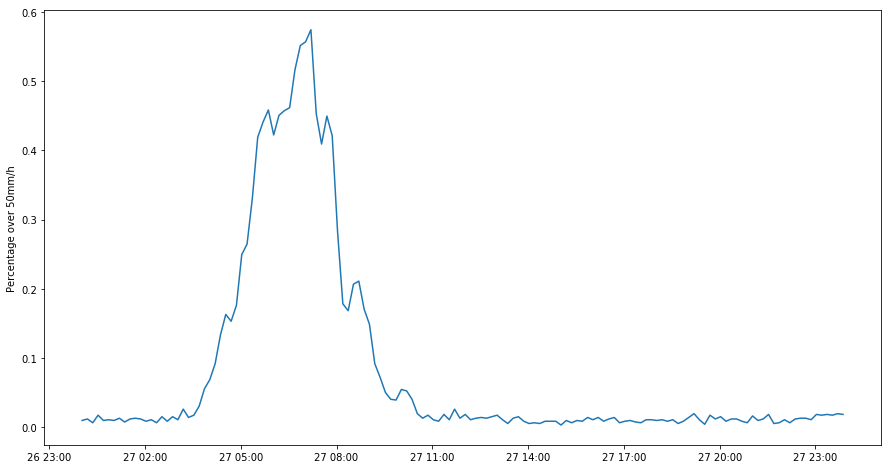

In [17]:
myf = plt.figure(figsize=[15,8])
plt.plot(file_dt_list, my_data)

myFmt = mdates.DateFormatter('%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Percentage over 50mm/h')


In [18]:
def fetch_QVP(filename):
    radar = pyart.aux_io.read_odim_h5(filename)
    this_QVP = pyart.retrieve.quasi_vertical_profile(radar)
    del radar
    return this_QVP

In [19]:
future = client.map(fetch_QVP, file_list)

In [20]:
progress(future)

VBox()

/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(FloatProgress).__init__(height='10px').
object.__init__() takes no parameters
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(HTML).__init__(width='140px').
object.__init__() takes no parameters
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


In [21]:
my_qvps = client.gather(future)

In [22]:
th_qvp = np.ma.empty([len(file_dt_list), len(my_qvps[0]['height'])])
for i in range(len(my_qvps)):
    th_qvp[i] = my_qvps[i]['reflectivity']

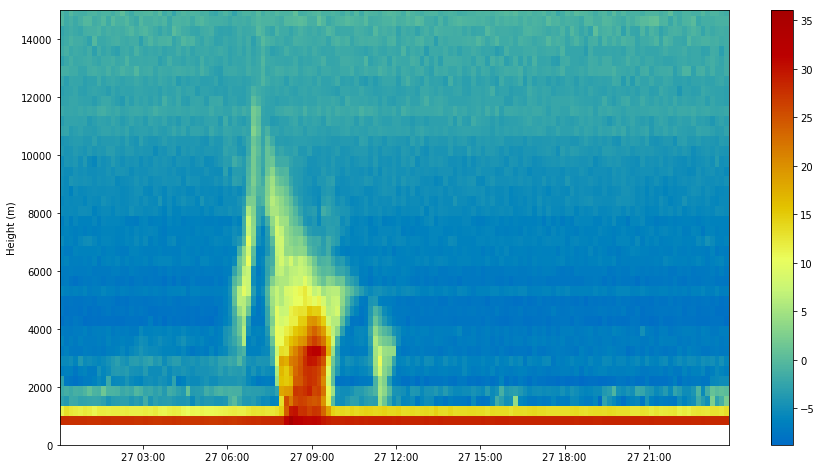

In [23]:
myf = plt.figure(figsize=[15,8])
plt.pcolor(file_dt_list,my_qvps[0]['height'], th_qvp.transpose(),
          cmap = pyart.graph.cm_colorblind.HomeyerRainbow)

myFmt = mdates.DateFormatter('%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([0,15000])
plt.ylabel('Height (m)')
plt.colorbar()


In [28]:
def fetch_QVP_cpol(filename):
    exf = ['temperature', 'specific_attenuation_reflectivity', 'specific_attenuation_differential_reflectivity', 
           'radar_echo_classification', 'radar_estimated_rain_rate', 'D0', 'NW', 'velocity', 
           'region_dealias_velocity', 'velocity_texture', 'total_power', 
           'cross_correlation_ratio', 
           'differential_phase', 'corrected_differential_phase', 'corrected_specific_differential_phase', 
           'spectrum_width', 'signal_to_noise_ratio']
    radar = pyart.io.read(filename, exclude_fields=exf)
    this_QVP = pyart.retrieve.quasi_vertical_profile(radar)
    del radar
    return this_QVP

mydir = '/lcrc/group/earthscience/radar/CPOL_level_1b/PPI/2006/20060122/'
new_fl = os.listdir(mydir)
for i in range(len(new_fl)):
    new_fl[i] = mydir + new_fl[i]

new_fl.sort()

In [29]:
future = client.map(fetch_QVP_cpol, new_fl)

In [30]:
progress(future)

VBox()

/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(FloatProgress).__init__(height='10px').
object.__init__() takes no parameters
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/homes/scollis/anaconda/envs/dask/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(HTML).__init__(width='140px').
object.__init__() takes no parameters
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


In [31]:
my_qvps = client.gather(future)

In [32]:
th_qvp = np.ma.empty([len(my_qvps), len(my_qvps[0]['height'])])
th_zdr = np.ma.empty([len(my_qvps), len(my_qvps[0]['height'])])

tim = [0]*len(my_qvps)
for i in range(len(my_qvps)):
    th_qvp[i] = my_qvps[i]['reflectivity']
    th_zdr[i] = my_qvps[i]['corrected_differential_reflectivity']
    tim[i] = num2date(my_qvps[i]['time']['data'][0], units=my_qvps[i]['time']['units'])

#atim = np.array(tim)
#order = atim.argsort()

#ordered_time = atim[order]
#ordered_qvps = th_qvp[order, :]


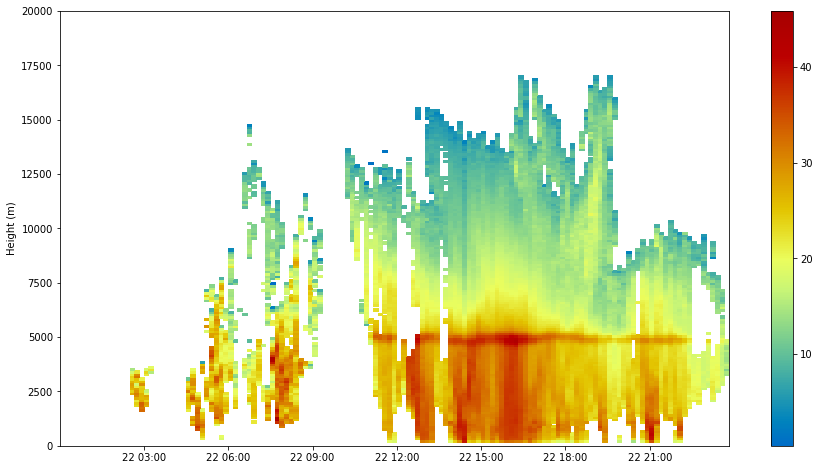

In [33]:
myf = plt.figure(figsize=[15,8])
plt.pcolor(tim,my_qvps[0]['height'], th_qvp.transpose(),
          cmap = pyart.graph.cm_colorblind.HomeyerRainbow)

myFmt = mdates.DateFormatter('%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([0,20000])
plt.ylabel('Height (m)')
plt.colorbar()


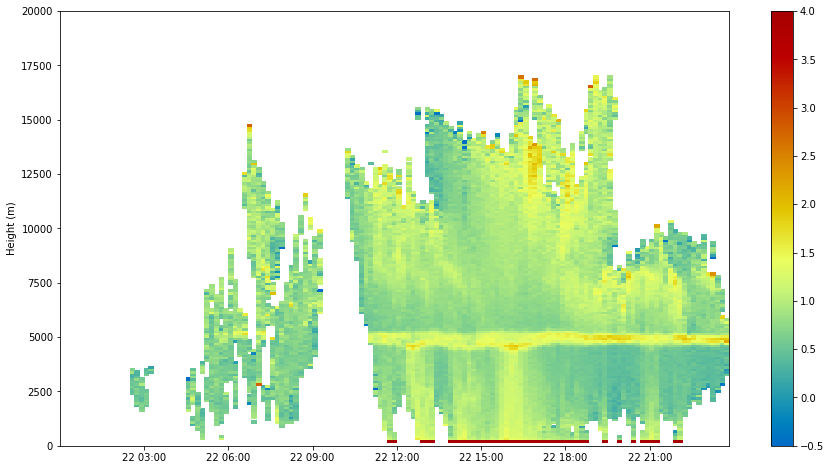

In [34]:
myf = plt.figure(figsize=[15,8])
plt.pcolor(tim,my_qvps[0]['height'], th_zdr.transpose(),
          cmap = pyart.graph.cm_colorblind.HomeyerRainbow,
          vmin = -0.5, vmax = 4)

myFmt = mdates.DateFormatter('%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([0,20000])
plt.ylabel('Height (m)')
plt.colorbar()
